### API for coordinates

In [1]:
import requests
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import rioxarray
import rasterio
from rasterio import mask
import geojson
import matplotlib as plt
from matplotlib import pyplot as plt
import geopandas
from shapely.geometry import box
import georasters as gr
from osgeo import gdal
from rasterio.plot import show
%matplotlib inline

In [2]:
address = "Deken Verbiststraat 6 2910 Essen" 

In [3]:
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

In [4]:
polygon = get_coordinates(address)
polygon

[[156267.31502358615, 238841.7716236934],
 [156267.14926358312, 238842.83581569418],
 [156261.62452758104, 238841.99485569447],
 [156263.34574358165, 238830.7386636883],
 [156267.87694358826, 238831.46563968807],
 [156268.3200795874, 238828.28023168445],
 [156269.71374358982, 238827.10359168425],
 [156273.30676759034, 238827.60343168303],
 [156274.37230359018, 238828.8659596853],
 [156273.80519958586, 238832.94199168682],
 [156273.14894358814, 238832.850791689],
 [156271.95617558807, 238840.53655169532],
 [156269.88743958622, 238840.21552769467],
 [156269.76647958905, 238840.92682369426],
 [156268.88468758762, 238841.57309569418],
 [156267.38030358404, 238841.352295693],
 [156267.31502358615, 238841.7716236934]]

In [5]:
from shapely.geometry import Polygon

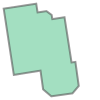

In [6]:
polygon_shapely = Polygon(polygon)
polygon_shapely

In [7]:
x_polygon = [x[0] for x in polygon]
y_polygon = [x[1] for x in polygon]

x_left = min(x_polygon)
x_right = max(x_polygon)
y_bottom = min(y_polygon)
y_top = max(y_polygon)

(x_left, x_right, y_bottom, y_top)

(156261.62452758104,
 156274.37230359018,
 238827.10359168425,
 238842.83581569418)

### Make shapefile, clip & plot (other way)

In [8]:
import shapefile

In [9]:
write = shapefile.Writer("shapefiles/test/polygon")
write.field("name", "C")

write.poly([polygon])
write.record("polygon_1")

write.close()

In [10]:
polygon_path = "/home/becode/3D-House/3D-House-Project/shapefiles/test/polygon.shp"

Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.


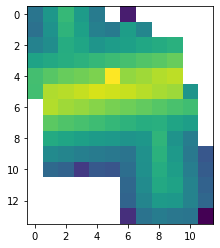

<AxesSubplot:>

In [11]:
#DSM clip
OutTile = gdal.Warp("/home/becode/3D-House/3D-House-Project/shapefiles/test/DSM_clip2.tif", 
                    "/home/becode/3D-House/3D-House-Project/Data/DSM/DSM-1/GeoTIFF/DHMVIIDSMRAS1m_k01.tif", 
                    cutlineDSName=polygon_path,
                    cropToCutline=True,
                    dstNodata = 0)

OutTile = None 

DSM_clip = rioxarray.open_rasterio("/home/becode/3D-House/3D-House-Project/shapefiles/test/DSM_clip2.tif", masked = True)
show(DSM_clip)

Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.


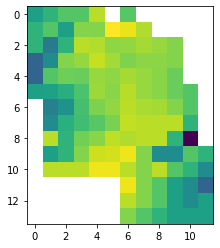

<AxesSubplot:>

In [12]:
OutTile_2 = gdal.Warp("/home/becode/3D-House/3D-House-Project/shapefiles/test/DTM_clip2.tif", 
                    "/home/becode/3D-House/3D-House-Project/Data/DTM/DTM-1/GeoTIFF/DHMVIIDTMRAS1m_k01.tif", 
                    cutlineDSName=polygon_path,
                    cropToCutline=True,
                    dstNodata = 0)

OutTile_2 = None 

DTM_clip = rioxarray.open_rasterio("/home/becode/3D-House/3D-House-Project/shapefiles/test/DTM_clip2.tif", masked = True)
show(DTM_clip)

In [13]:
image = DSM_clip - DTM_clip

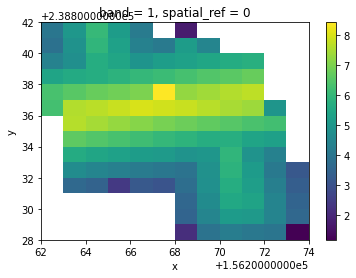

In [14]:
image.plot()

In [16]:
#image before, gotta change the nan into zero
image

<xarray.DataArray (band: 1, y: 14, x: 12)>
array([[[4.0200005, 5.0200005, 6.039999 , 5.1499996, 4.160001 ,
               nan, 1.7288189,       nan,       nan,       nan,
               nan,       nan],
        [3.880001 , 4.870001 , 5.92     , 5.289999 , 4.33     ,
         4.127096 , 5.1711817, 4.4816628,       nan,       nan,
               nan,       nan],
        [4.3999996, 4.7699995, 5.6800003, 5.4300013, 4.9414415,
         5.1778173, 5.2969217, 5.4734764, 5.6258717, 5.76     ,
               nan,       nan],
        [5.420001 , 5.579999 , 5.6800003, 5.826543 , 5.9979153,
         6.124156 , 6.290742 , 6.44839  , 6.578622 , 6.7299995,
               nan,       nan],
        [6.3200006, 6.539999 , 6.7342787, 6.845091 , 6.9860916,
         8.428166 , 7.243675 , 7.3961563, 7.5887957, 7.7053223,
               nan,       nan],
        [6.26     , 7.579504 , 7.6831665, 7.811754 , 7.9856205,
         7.8991785, 7.8102455, 7.646002 , 7.488723 , 7.365324 ,
         4.9699993,       nan],
        [      nan, 7.6266603, 7.437295 , 7.283373 , 7.121374 ,
         6.9468327, 6.8      , 6.662655 , 6.513441 , 6.3500004,
...
         6.001586 , 5.858284 , 5.6899996, 5.7200003, 5.4000006,
         5.26     ,       nan],
        [      nan, 5.6000013, 5.4400005, 5.293171 , 5.1488543,
         5.0889854, 4.9015465, 4.9800005, 5.910001 , 4.8999996,
         4.34     ,       nan],
        [      nan, 4.67     , 4.49     , 4.299999 , 4.1562366,
         4.0453224, 3.9299994, 4.83     , 5.8499994, 5.12     ,
         4.1000004, 3.1599998],
        [      nan, 3.6400003, 3.4700003, 2.3900003, 3.170001 ,
         3.0600004, 3.7600012, 4.799999 , 5.660001 , 5.209999 ,
         4.2700005, 3.3100004],
        [      nan,       nan,       nan,       nan,       nan,
               nan, 3.5700006, 4.66     , 5.539999 , 5.380001 ,
         4.45     , 3.4900007],
        [      nan,       nan,       nan,       nan,       nan,
               nan, 3.4800005, 4.4699993, 5.120001 , 5.0699997,
         4.4399996, 3.6100006],
        [      nan,       nan,       nan,       nan,       nan,
               nan, 2.119999 , 3.9300003, 4.2199993, 4.08     ,
         4.01     , 1.1800003]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.563e+05 1.563e+05 ... 1.563e+05 1.563e+05
  * y            (y) float64 2.388e+05 2.388e+05 ... 2.388e+05 2.388e+05
    spatial_ref  int64 0

In [66]:
new_image = np.where(np.isnan(image), 0, image)
#print(new_image)
image_2 = np.pad(new_image[0], pad_width = 1, mode ="constant", constant_values = 0)

print(image_2)

[[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.       ]
 [0.        4.0200005 5.0200005 6.039999  5.1499996 4.160001  0.
  1.7288189 0.        0.        0.        0.        0.        0.       ]
 [0.        3.880001  4.870001  5.92      5.289999  4.33      4.127096
  5.1711817 4.4816628 0.        0.        0.        0.        0.       ]
 [0.        4.3999996 4.7699995 5.6800003 5.4300013 4.9414415 5.1778173
  5.2969217 5.4734764 5.6258717 5.76      0.        0.        0.       ]
 [0.        5.420001  5.579999  5.6800003 5.826543  5.9979153 6.124156
  6.290742  6.44839   6.578622  6.7299995 0.        0.        0.       ]
 [0.        6.3200006 6.539999  6.7342787 6.845091  6.9860916 8.428166
  7.243675  7.3961563 7.5887957 7.7053223 0.        0.        0.       ]
 [0.        6.26      7.579504  7.6831665 7.811754  7.9856205 7.8991785
  7.8102455 7.646002  7.488723  7.365324  4.9699993 0.        0.       ]
 [

In [67]:
image_2.shape

(16, 14)

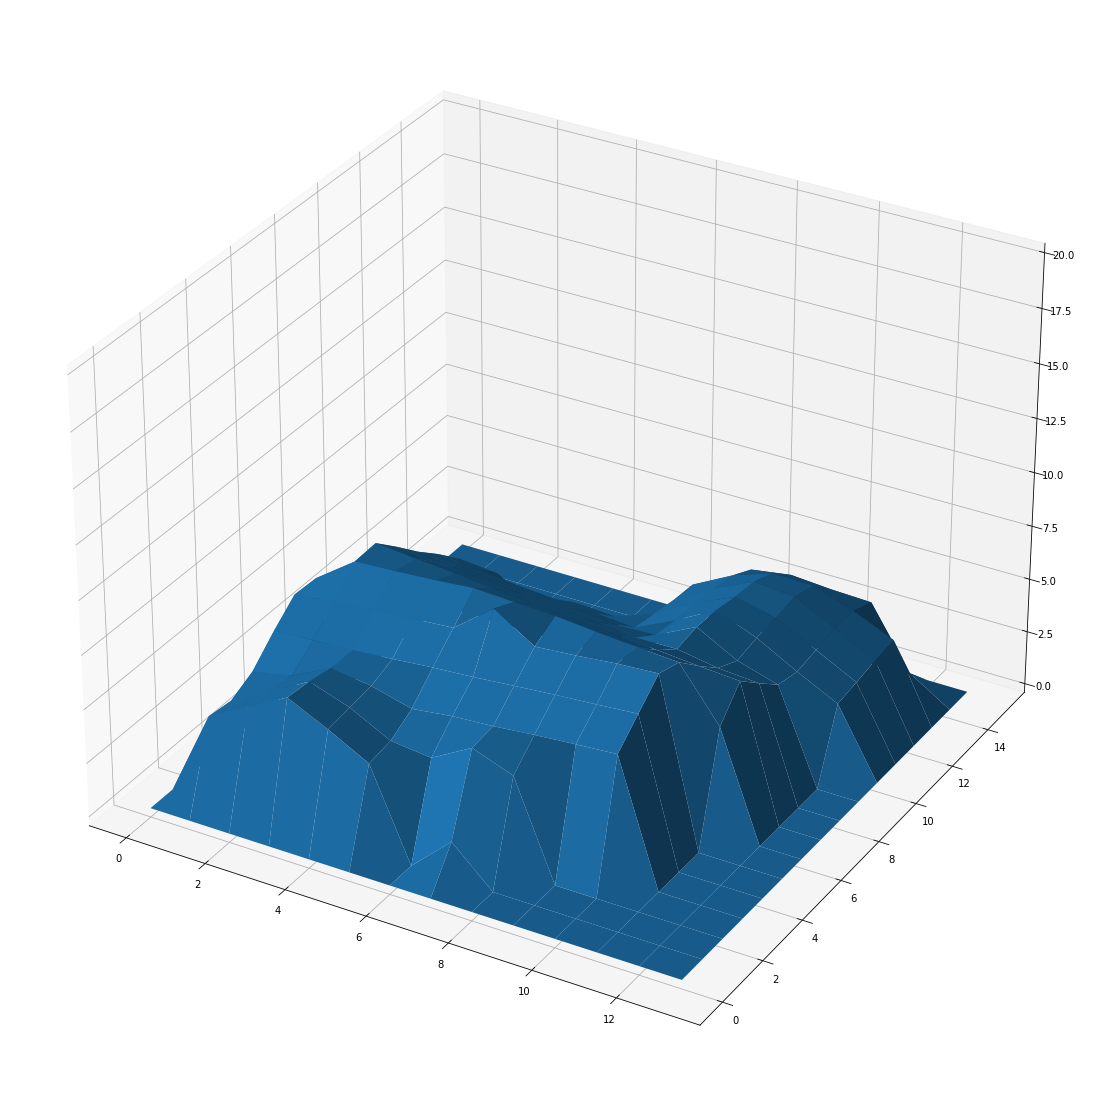

In [68]:
ab = image_2.shape[0]
ac = image_2.shape[1]

x, y = np.meshgrid(np.arange(ac), np.arange(ab))
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x, y, image_2)
ax.set_zlim(0, 20)
plt.show()

In [21]:
pwd

'/home/becode/3D-House/3D-House-Project'

In [22]:
polygon[0]

[156267.31502358615, 238841.7716236934]

<AxesSubplot:>

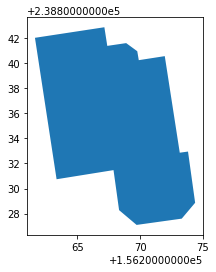

In [23]:
# Read test file

path = "/home/becode/3D-House/3D-House-Project/shapefiles/test/polygon.shp"
test = gpd.read_file(path)
test.plot()

In [24]:

#geometries = [{"Type": "Polygon", "Coordinate Points": polygon}]
#xds = rioxarray.open_rasterio(
#"Data/DSM/DSM-1/GeoTIFF/DHMVIIDSMRAS1m_k01.tif", masked = True).rio.clip(geometries, from_disk=True)

In [25]:
#geometries = {"type": "Polygon", "coordinates": [polygon]}
#xds = rioxarray.open_rasterio(
#    "Data/DSM/DSM-1/GeoTIFF/DHMVIIDSMRAS1m_k01.tif", masked = True)
#print(type(xds))

In [26]:
#type(geometries)

In [27]:

#cropping_geometries = [geojson.loads(geometries.content.decode("utf-8"))]
##json.loads(myResponse.content.decode('utf-8'))
#print(type(cropping_geometries))
##xds.rio.clip(geometries=cropping_geometries, from_disk=True)



In [28]:
#"""
#geometry = ''' {"type": "Polygon",
#    ...                 "coordinates": [
#    ...                 [[-94.07955380199459, 41.69085871273774],
#    ...                 [-94.06082436942204, 41.69103313774798],
#    ...                 [-94.06063203899649, 41.67932439500822],
#    ...                 [-94.07935807746362, 41.679150041277325],
#    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
#    >>> cropping_geometries = [geojson.loads(geometry)]
#    >>> xds = xarray.open_rasterio('cool_raster.tif')
#    >>> cropped = xds.rio.clip(geometries=cropping_geometries, crs=4326)
#